### Importing the libraries

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import seaborn as sns 
from scipy.optimize import curve_fit
from IPython.display import display, HTML

%matplotlib inline


### Loading the dataset

In [26]:
order_products_train = pd.read_csv("./instacart-market-basket-analysis/order_products__train.csv")
order_products_prior = pd.read_csv("./instacart-market-basket-analysis/order_products__prior.csv")
orders = pd.read_csv("./instacart-market-basket-analysis/orders.csv")
products = pd.read_csv("./instacart-market-basket-analysis/products.csv")
aisles = pd.read_csv("./instacart-market-basket-analysis/aisles.csv")
departments = pd.read_csv("./instacart-market-basket-analysis/departments.csv")
sample_submission = pd.read_csv("./instacart-market-basket-analysis/sample_submission.csv")


### Check the size of the 'orders' and 'products' files

In [27]:
print(orders.shape)
print(products.shape) 

(3421083, 7)
(49688, 4)


### There are around 3.5 million orders and around 50000 products

### We check the order information

In [28]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [29]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Number of orders per customer from max to min

In [30]:
sns.set_style('dark')
customer_no = orders.groupby("user_id", as_index = False)["order_number"].max() 
customer_no

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


Text(0.5, 1.0, 'Number of Orders per Customer')

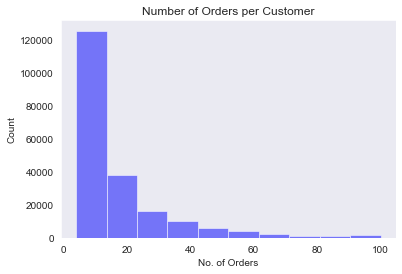

In [31]:
num_bins = 10
n, bins, patches = plt.hist(customer_no["order_number"] , num_bins, color='blue', alpha=0.5)

plt.xlabel("No. of Orders")
plt.ylabel("Count")
plt.title("Number of Orders per Customer")

### Check the statistics of the customer data

In [32]:
## MEAN

mean_value = customer_no["order_number"].mean()
mean_value

16.590367054784224

In [33]:
## Standard Deviation

std_deviation = customer_no["order_number"].std()
std_deviation

16.654773501154427

### What are the most frequently purchased products in the dataset ?
### OR
### What products do consumers buy most often ?

In [34]:
## Merging the train and prior datasets

t_p = order_products_train.append(order_products_prior,ignore_index = True)
prod = t_p.groupby("product_id",as_index = False)["order_id"].count() 

### Check the total number of products present in the dataset (Train + Prior)

In [37]:
prod

,product_id,order_id
0,1,1928
1,2,94
2,3,283
3,4,351
4,5,16
...,...,...
49680,49684,9
49681,49685,49
49682,49686,127
49683,49687,14


In [38]:
top = 20
product_Count = prod.sort_values("order_id",ascending = False)
df1 = product_Count.iloc[0:top,:]
df1 = df1.merge(products,on = "product_id")
display(df1.loc[:,["product_name"]])

,product_name
0,Banana
1,Bag of Organic Bananas
2,Organic Strawberries
3,Organic Baby Spinach
4,Organic Hass Avocado
5,Organic Avocado
6,Large Lemon
7,Strawberries
8,Limes
9,Organic Whole Milk


### By finding the most frequently purchased products we make the following observations 

#### 1) Produce has the most demand and consumers tend to buy produce more often. This could be because produce consists of perishable items.
#### 2) People buy organic food, despite the fact that it is expensive

### How many products does each department have ?

In [39]:
x = pd.merge(left=products, right=departments, how='left')
lists = pd.merge(left = x, right=aisles, how='left')
lists 

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation
...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,alcohol,spirits
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen,frozen vegan vegetarian
49685,49686,Artisan Baguette,112,3,bakery,bread
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,pets,cat food care


In [40]:
# Count the total number of products present in each department
group_list = lists.groupby("department")["product_id"].aggregate({'Total_products': 'count'}) 
group_list


SpecificationError: nested renamer is not supported

### We try to explore the total number of products present in each department in a descending order

In [41]:
final = group_list.reset_index() 
final.sort_values(by='Total_products', ascending=False, inplace=True)
final

NameError: name 'group_list' is not defined

In [42]:
sns.set_style('white') 
ax = sns.barplot(x="Total_products", y="department", data=final,color = 'gray' )
#fig, ax = plt.subplots()

r = ax.spines["right"].set_visible(False)
#l = ax.spines["left"].set_visible(False)
t = ax.spines["top"].set_visible(False)



NameError: name 'final' is not defined

### We make the following observations -

#### 1) Personal care has the maximum number of products. This could be because personal care has many sub-categories like health-care items, cosmetics, deodrants, skin care products, bathroom essentials, etc. All these sub-categories consist of a huge variety of products and hence the count is maximum.

#### 2) Bulk department has the least number of products. This could be because it has very few items as consumers prefer to buy such items from a store.

In [43]:
my_range=list(range(1,len(final.index)+1))

NameError: name 'final' is not defined

### We also plot and observe a bubble plot for the products in each department

In [44]:
fig, ax = plt.subplots(figsize=(5,3.5))
plt.hlines(y=my_range, xmin=0, xmax=final['Total_products'], color='#007acc', alpha=0.2, linewidth=5)
plt.plot(final['Total_products'], my_range, "o", markersize=5, color='#007acc', alpha=0.6)

NameError: name 'my_range' is not defined

### Check the order_products_prior and order_products_train dataset

In [45]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [46]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [47]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior.head() 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [48]:
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior.head() 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients


In [49]:
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head() 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


### Create a new dataframe consisting of 'add_to_cart_order' and 'reordered' products from the prior set

In [50]:
new_df = pd.DataFrame({'Add_to_cart': order_products_prior.add_to_cart_order, 'Reordered':order_products_prior.reordered })
new_df

,Add_to_cart,Reordered
0,1,1
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
32434484,6,1
32434485,7,0
32434486,8,0
32434487,9,1


### Which department has the highest and lowest number of reordered items ?


C:\Users\patil\anaconda3\envs\ECE_143\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


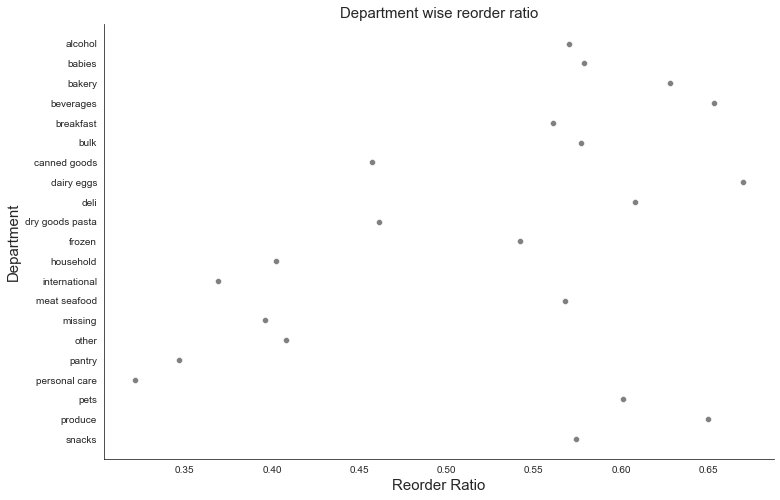

In [52]:
## Group the departments by the reordered items . Take an average of reordered per department to find the department 
## with the maximum number of reordered items
new_df = pd.DataFrame({'Add_to_cart': order_products_prior.add_to_cart_order, 'Reordered':order_products_prior.reordered })
df2 = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.set_style('white')

ax1 = sns.scatterplot(df2['reordered'].values,df2['department'].values , color = 'gray')
plt.ylabel('Department', fontsize=15)
plt.xlabel('Reorder Ratio' , fontsize=15)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='horizontal')
r = ax1.spines["right"].set_visible(False)
t = ax1.spines["top"].set_visible(False)
plt.show() 

### We conclude that

#### 1) Personal care department has the lowest number of reordered items or the lowest reordered ratio.
#### 2) Dairy eggs have department have the highest number of reordered items or the highest reordered ratio.